**PSO FUNCTION**

In [ ]:
import math
import random

def flatten(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, list):
            flat_list.extend(flatten(item))
        else:
            flat_list.append(item)
    return flat_list

def unflatten(flat_list, structure):
    flat_iter = iter(flat_list)
    def helper(struct):
        result = []
        for elem in struct:
            if isinstance(elem, list):
                result.append(helper(elem))
            else:
                result.append(next(flat_iter))
        return result
    return helper(structure)

def pso_function(parameter_values, bounds, n_particles, m_iterations, inertia, cognitive, social):

    print("PSO Algorithm Started")

    num_particles = n_particles
    max_iterations = m_iterations
    w = inertia  # inertia weight
    c1 = cognitive  # cognitive constant
    c2 = social  # social constant

    para = flatten(parameter_values)
    len_para = len(para)
    update_bounds = flatten(bounds)


    particles = []
    velocities = []
    pbest = []
    gbest = None
    gbest_value = -float('inf')
    iteration_best_values = []

    for _ in range(num_particles):
        particle = [random.uniform(bounds[i][0], bounds[i][1]) for i in range(len_para)]
        temp_con = unflatten(particle, parameter_values)
        while (conditions(temp_con) == False):
            particle = [random.uniform(bounds[i][0], bounds[i][1]) for i in range(len_para)]
            temp_con = unflatten(particle, parameter_values)
        particles.append(particle)
        velocities.append([0] * (len_para))
        pbest.append(particle[:])

    # PSO loop
    for iter in range(max_iterations):
        iteration_best_value = -float('inf')
        for i in range(num_particles):
            current_position = particles[i]
            temp = unflatten(current_position, parameter_values)
            fitness = objective_function(temp)

            # Update personal best
            temp = unflatten(pbest[i], parameter_values)
            if fitness > objective_function(temp):
                pbest[i] = current_position[:]

            # Update global best
            if fitness > gbest_value:
                gbest = current_position[:]
                gbest_value = fitness

            # Update iteration best value
            if fitness > iteration_best_value:
                iteration_best_value = fitness

        # Record the best value found in this iteration
        iteration_best_values.append(iteration_best_value)

        # Update velocities and particles
        for i in range(num_particles):
            for j in range(len_para):
                new_velocity = (w * velocities[i][j] +
                                    c1 * random.random() * (pbest[i][j] - particles[i][j]) +
                                    c2 * random.random() * (gbest[j] - particles[i][j]))
                new_position = particles[i][j] + new_velocity

                new_position = max(min(new_position, update_bounds[j][1]), update_bounds[j][0])

                # Update only if the new position satisfies the condition
                particles[i][j] = new_position
                velocities[i][j] = new_velocity

                temp_con = unflatten(particles[i], parameter_values)
                if not conditions(temp_con):
                    particles[i][j] -= new_velocity
                    velocities[i][j] = 0
        #Printing
        if (iter % 100 == 0) or iter == (max_iterations-1):
                print(f"Iteration {iter}: Value = {iteration_best_values[iter]}")

    return iteration_best_values

**MAIN PROGRAM**

Constant Variables Initialization

In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [ ]:
def up_get_ini(alpha_K0, alpha_K_dash0, P_s0, W_0, h_as, h_ak, sigma_k, h_ac, h_sc, sigma_c, K_dash, sigma_k_dash, h_ak_dash, h_sk, h_ik, h_si, h_sk_dash, h_ik_dash, varphi_r, varphi_t):

    SINRKK = 0.0
    SINRKK_dash = 0.0
    SINRCC = 0.0

    k = 0
    k_dash = 0

    SINRKK = (alpha_K0 * P_s0 * (np.abs(h_sk[k][0] + np.dot(np.dot(h_ik[k],varphi_r),h_si).item()))**2) / (P_s0 * (np.abs(h_sk[k][0] + np.dot(np.dot(h_ik[k],varphi_r),h_si).item()))**2 * (alpha_K_dash0) + (np.abs(np.dot(W_0,h_ak[k])))**2 + sigma_k**2)

    SINRCC = (np.abs(np.dot(W_0,h_ac)))**2 / (P_s0 * np.abs(h_sc)**2 + sigma_c**2)

    SINRKK_dash = (alpha_K_dash0 * P_s0 * (np.abs(h_sk_dash[k_dash][0] + np.dot(np.dot(h_ik_dash[k_dash],varphi_t),h_si).item()))**2) / ((np.abs(np.dot(W_0,h_ak_dash[k_dash])))**2 + sigma_k_dash**2)

    rho = 0.01
    P_I =  np.abs(np.dot(W_0,h_as))**2 + (rho**2 * P_s0)

    return SINRCC, SINRKK, SINRKK_dash, P_I

In [ ]:
def generate_channel(N, K, path_loss):

    h = (1/np.sqrt(2)) * (np.random.randn(N, K) + 1j * np.random.randn(N, K))
    h_normalized = h / np.linalg.norm(h, axis=0)
    h = path_loss * h_normalized

    return h

In [ ]:
def up_GET_dist_pru(P_AP, P_DD, P_CC, P_KK, P_IRS, P_KK_dash, noise):


    pathloss_direct = lambda d: 32.6 + 36.7 * math.log10(d)

    relative_user_loc = [x1 - x2 for x1, x2 in zip(P_AP, P_DD)]
    d_as = math.sqrt(relative_user_loc[0]**2 + relative_user_loc[1]**2)
    PL_as = pathloss_direct(d_as)
    PL_as = math.sqrt(10**((- noise - PL_as) / 10))

    relative_user_loc = [x - y for x, y in zip(P_AP, P_CC)]
    d_ac = math.sqrt(relative_user_loc[0]**2 + relative_user_loc[1]**2)
    PL_ac = pathloss_direct(d_ac)
    PL_ac = math.sqrt(10**((- noise - PL_ac) / 10))

    relative_user_loc = [x - y for x, y in zip(P_AP, P_KK)]
    d_ak = math.sqrt(relative_user_loc[0]**2 + relative_user_loc[1]**2)
    PL_ak = pathloss_direct(d_ak)
    PL_ak = math.sqrt(10**((- noise - PL_ak) / 10))

    relative_user_loc = [x - y for x, y in zip(P_DD, P_KK)]
    d_sk = math.sqrt(relative_user_loc[0]**2 + relative_user_loc[1]**2)
    PL_sk = pathloss_direct(d_sk)
    PL_sk = math.sqrt(10**((- noise - PL_sk) / 10))

    relative_user_loc = [x - y for x, y in zip(P_IRS, P_KK)]
    d_ik = math.sqrt(relative_user_loc[0]**2 + relative_user_loc[1]**2)
    PL_ik = pathloss_direct(d_ik)
    PL_ik = math.sqrt(10**((- noise - PL_ik) / 10))

    relative_user_loc = [x - y for x, y in zip(P_DD, P_IRS)]
    d_si = math.sqrt(relative_user_loc[0]**2 + relative_user_loc[1]**2)
    PL_si = pathloss_direct(d_si)
    PL_si = math.sqrt(10**((- noise - PL_si) / 10))

    relative_user_loc = [x - y for x, y in zip(P_DD, P_CC)]
    d_sc = math.sqrt(relative_user_loc[0]**2 + relative_user_loc[1]**2)
    PL_sc = pathloss_direct(d_sc)
    PL_sc = math.sqrt(10**((- noise - PL_sc) / 10))

    relative_user_loc = [x - y for x, y in zip(P_AP, P_KK_dash)]
    d_ak_dash = math.sqrt(relative_user_loc[0]**2 + relative_user_loc[1]**2)
    PL_ak_dash = pathloss_direct(d_ak_dash)
    PL_ak_dash = math.sqrt(10**((- noise - PL_ak_dash) / 10))

    relative_user_loc = [x - y for x, y in zip(P_DD, P_KK_dash)]
    d_sk_dash = math.sqrt(relative_user_loc[0]**2 + relative_user_loc[1]**2)
    PL_sk_dash = pathloss_direct(d_sk_dash)
    PL_sk_dash = math.sqrt(10**((- noise - PL_sk_dash) / 10))

    relative_user_loc = [x - y for x, y in zip(P_IRS, P_KK_dash)]
    d_ik_dash = math.sqrt(relative_user_loc[0]**2 + relative_user_loc[1]**2)
    PL_ik_dash = pathloss_direct(d_ik_dash)
    PL_ik_dash = math.sqrt(10**((- noise - PL_ik_dash) / 10))

    return (PL_as, PL_ac, PL_ak, PL_sk, PL_ik, PL_si, PL_sc, PL_ak_dash, PL_sk_dash, PL_ik_dash)

In [ ]:
M = 2  # number of antennas on AP
N = 8  # number IRS elements
K = 1  # no.of user at receiver side
K_dash = 1  # no.of user at transmission side


P_AP = [0, 0]  # in meters
P_DD = [150, -10]
P_CC = [10, -160]
P_IRS = [170, -110]
P_KK = [100, -150]
P_KK_dash = [250, -70]
noise = -120

PL_as, PL_ac, PL_ak, PL_sk, PL_ik, PL_si, PL_sc, PL_ak_dash, PL_sk_dash, PL_ik_dash = up_GET_dist_pru(P_AP, P_DD, P_CC, P_KK, P_IRS, P_KK_dash, noise)

h_as= generate_channel(M,1,PL_as);
h_ac= generate_channel(M,1,PL_ac);
h_ak= generate_channel(M,K,PL_ak);
h_ak = h_ak.transpose() #For own Easy
h_sk = generate_channel(1,K,PL_sk);
h_sk = np.conjugate(h_sk.transpose())

h_ik= generate_channel(N,K,PL_ik);
h_ik = np.conjugate(h_ik.transpose())

h_si= generate_channel(1,N,PL_si);
h_si = h_si.transpose()

h_sc= generate_channel(1,1,PL_sc);
h_ak_dash= generate_channel(M,K_dash,PL_ak_dash);
h_ak_dash = h_ak_dash.transpose() #For own Easy
h_sk_dash= generate_channel(1,K_dash,PL_sk_dash);
h_sk_dash = np.conjugate(h_sk_dash.transpose())
h_ik_dash= generate_channel(N,K_dash,PL_ik_dash);
h_ik_dash = np.conjugate(h_ik_dash.transpose())


sigma_c = 1
sigma_k = 1
sigma_k_dash = 1

**CONSTRAINTS CONDITIONS CHECK FUNCTION**

In [ ]:
def conditions(para):
    W_0_real, W_0_imaginary, P_s0_list, alpha_K0_list, zeta_r, theta_r, theta_t = para
    P_s0 = P_s0_list[0]
    alpha_K0 = alpha_K0_list[0]
    alpha_K_dash0 = 1-alpha_K0
    zeta_t = [1 - z for z in zeta_r]

    W_0 = np.array([real + 1j * imaginary for real, imaginary in zip(W_0_real, W_0_imaginary)])

    varphi_r_value = [math.sqrt(zeta) * math.exp(theta) for zeta, theta in zip(zeta_r, theta_r)]
    varphi_r = np.zeros((N, N), dtype=complex)
    np.fill_diagonal(varphi_r, varphi_r_value)

    varphi_t_value = [math.sqrt(zeta) * math.exp(theta) for zeta, theta in zip(zeta_t, theta_t)]
    varphi_t = np.zeros((N, N), dtype=complex)
    np.fill_diagonal(varphi_t, varphi_t_value)

    SINRCC, SINRKK, SINRKK_dash, P_I = up_get_ini(alpha_K0, alpha_K_dash0, P_s0, W_0, h_as, h_ak, sigma_k, h_ac, h_sc, sigma_c, K_dash, sigma_k_dash, h_ak_dash, h_sk, h_ik, h_si, h_sk_dash, h_ik_dash, varphi_r, varphi_t)
    rateSINRCC = math.log2(SINRCC.item() + 1)
    rateSINRKK = math.log2(SINRKK.item() + 1)
    rateSINRKK_dash = math.log2(SINRKK_dash.item() + 1)

    R_min_k=0.05
    R_min_k_dash=R_min_k
    R_min_c=0.05
    P_max = 10**(10/10)
    P_I_min = 10**(9/10)
    P_I_max = 2*P_I_min
    eta = 0.01

    if P_I < P_I_min:
      P_sh = 0
    elif P_I >= P_I_min and P_I <= P_I_max:
      P_sh = eta * P_I
    elif P_I > P_I_max:
      P_sh = eta * P_I_max

    condition_1 = (rateSINRKK >= R_min_k) and (rateSINRKK_dash >= R_min_k_dash)
    condition_3 = rateSINRCC >= R_min_c
    condition_4 = all(np.abs(w)**2 <= P_max for w in W_0)
    condition_5 = P_s0 <= P_sh
    condition_6 = P_I >= P_I_min

    if (condition_1 and condition_3 and condition_4 and condition_5 and condition_6):
        return True
    return False

**RATE CALCULATION METHOD**

In [ ]:
def objective_function(para):
    W_0_real, W_0_imaginary, P_s0_list, alpha_K0_list, zeta_r, theta_r, theta_t = para
    P_s0 = P_s0_list[0]
    alpha_K0 = alpha_K0_list[0]
    alpha_K_dash0 = 1-alpha_K0
    zeta_t = [1 - z for z in zeta_r]

    W_0 = np.array([real + 1j * imaginary for real, imaginary in zip(W_0_real, W_0_imaginary)])

    varphi_r_value = [math.sqrt(zeta) * math.exp(theta) for zeta, theta in zip(zeta_r, theta_r)]
    varphi_r = np.zeros((N, N), dtype=complex)
    np.fill_diagonal(varphi_r, varphi_r_value)

    varphi_t_value = [math.sqrt(zeta) * math.exp(theta) for zeta, theta in zip(zeta_t, theta_t)]
    varphi_t = np.zeros((N, N), dtype=complex)
    np.fill_diagonal(varphi_t, varphi_t_value)

    SINRCC, SINRKK, SINRKK_dash, P_I = up_get_ini(alpha_K0, alpha_K_dash0, P_s0, W_0, h_as, h_ak, sigma_k, h_ac, h_sc, sigma_c, K_dash, sigma_k_dash, h_ak_dash, h_sk, h_ik, h_si, h_sk_dash, h_ik_dash, varphi_r, varphi_t)
    rateSINRCC = math.log2(SINRCC.item() + 1)
    rateSINRKK = math.log2(SINRKK.item() + 1)
    rateSINRKK_dash = math.log2(SINRKK_dash.item() + 1)

    return rateSINRKK + rateSINRKK_dash

**PARAMETERS TO BE OPTIMIZED LIST**

In [ ]:
W_0_real = [random.uniform(0, 1) for _ in range(M)]
W_0_imaginary = [random.uniform(0, 1) for _ in range(M)]
P_s0 = [random.uniform(0, 1)]
alpha_K0 = [random.uniform(0, 1)]
zeta_r = [random.uniform(0, 1) for _ in range(N)]
theta_r = [random.uniform(0, 2*math.pi) for _ in range(N)]
theta_t = [random.uniform(0, 2*math.pi) for _ in range(N)]

par = W_0_real, W_0_imaginary, P_s0, alpha_K0, zeta_r, theta_r, theta_t

**BOUNDS**

For bounds, you have to create a list for the range of all variables of each optimizable parameter lists.

In this case, M = 2, N = 8

So there are *w_real* = **1x2**, *w_imaginary* = **1x2**, *p_s* = **1x1**, *alpha_k* = **1x1**, *zeta_r* = **1x8**, *theta_r* = **1x8**, *theta_t* = **1x8**

Suppose you have a 2D optimizable parameter list say **X = 3x2** size.

Then you have to mention **[lower limit, upper limit]*6**, (6 = the list length)

**3 More Cases:**

* In case there are no lower or upper range, you must use **[ -(float('inf')) , (float('inf')) ]**

* In case there is only no lower limit, you must use **-(float('inf'))** as lower limit

* In case there is only no upper limit, you must use **(float('inf'))** as upper limit

In [ ]:
bounds = [(0,1)]*M + [(0,1)]*M +[(0,1)]*(1) + [(0,1)]*K + [(0,1)]*N + [(0,2*math.pi)]*N + [(0,2*math.pi)]*N

**PSO FUNCTION PARAMETERS (YOU CAN CHANGE)**

In [ ]:
n_particles = 30
m_iterations = 200
inertia= 0.5
cognitive = 0.5
social = 0.5
number_of_simulations = 100 # Average of result of number of simulations (Any Integer Number)

**RESULT**

In [ ]:
average = []
for i in range(number_of_simulations):
    result = pso_function(par, bounds, n_particles, m_iterations, inertia, cognitive, social)
    average.append(result)

PSO Algorithm Started
Iteration 0: Value = 20.224176725819532
Iteration 100: Value = 23.650210979374666
Iteration 199: Value = 23.650210979645106


**AVERAGE OF SIMULATIONS RESULT**

In [ ]:
column_sums = [0] * len(average[0])

for row in average:
    for i in range(len(row)):
        column_sums[i] += row[i]

num_rows = len(average)
column_averages = [sum_value / num_rows for sum_value in column_sums]

**RESULT PLOTTING**

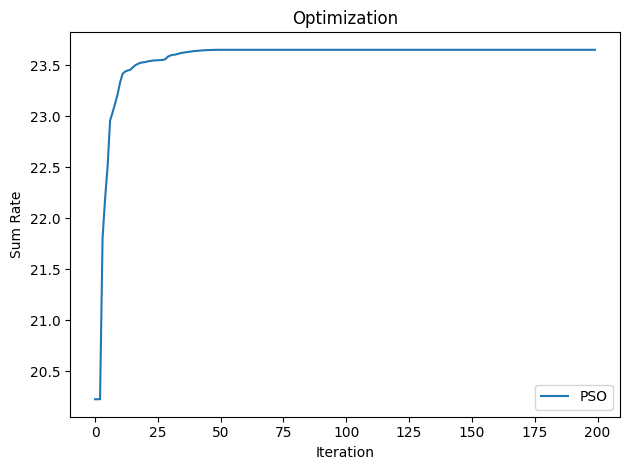

In [ ]:
plt.plot(np.arange(len(column_averages)), column_averages, label='Function Value')
plt.title('PSO Optimization')
plt.xlabel('Iteration')
plt.ylabel('Sum Rate')
plt.legend()
plt.tight_layout()
plt.show()